## K-Means lab

#### Data Description

The data used was cleaned. Check the EDA notebook for more details.

Data preprocessing has been done below before the training.

### Notebook Description

This notebook will cover the **K-Means** Classification Model.

Two models will be built in this notebook:

1. The first model will be using PCA.
2. The second model will **NOT** use PCA, it will include 3 original unchanged columns ['appearance', 'minutes_player', 'highest_value'].

## Import Libraries

In [212]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

## Load the Data

In [213]:
df = pd.read_csv("final_data_cleaned.csv")

In [214]:
df.shape

(6397, 19)

In [215]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,8,Manchester United,Defender Centre-Back,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758.0,47.0,13.0,0.0,2000000.0,2000000.0
1,10,Manchester United,Defender Left-Back,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132.0,182.0,15.0,3.0,22000000.0,22000000.0


## Preprocess the Data

In [216]:
# removing the unnamed column, no use for it
df.drop(columns='Unnamed: 0', inplace=True)

In [217]:
# dropping categorical columns, we only want numerical for K-means
df.drop(columns=['team', 'position'], inplace=True)

In [218]:
df.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value'],
      dtype='object')

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

#### 3. Feature selection

> First run, using PCA

In [219]:
# Example: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# Convert to a DataFrame for easier handling
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])


In [220]:
# PCA Dataset
df_pca.head()

,PC1,PC2,PC3
0,-2.623453e+06,-6.200566e+05,113.553748
1,2.537447e+07,-4.634557e+06,1623.898328
2,1.017634e+07,-1.026686e+06,-1171.528674
3,4.357312e+07,-7.243982e+06,-1795.757870
4,3.978006e+07,6.157984e+06,-1332.878517


> Second run manually selecting 3 features, Non-PCA set

In [221]:
# creating the correlation matrix
correlation = df.corr(numeric_only=True)

In [222]:
# printing the correlations for the column ''current_value'
print(correlation['current_value'].sort_values(ascending=False))

current_value          1.000000
highest_value          0.866764
appearance             0.408787
minutes played         0.408198
assists                0.150818
award                  0.138082
games_injured          0.130930
goals                  0.115648
days_injured           0.115438
height                 0.075398
second yellow cards   -0.006990
yellow cards          -0.010027
red cards             -0.014751
clean sheets          -0.023233
goals conceded        -0.032041
age                   -0.130619
Name: current_value, dtype: float64


In [223]:
# Set the correlation threshold
threshold = 0.4  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index.to_list()
selected_features.remove('current_value')

selected_features

['appearance', 'minutes played', 'highest_value']

In [224]:
# Non-PCA Dataset
df_no_pca = df[selected_features]
df_no_pca

,appearance,minutes played,highest_value
0,34.0,2758.0,2000000.0
1,89.0,7132.0,22000000.0
2,34.0,2686.0,12000000.0
3,72.0,5574.0,35000000.0
4,60.0,4783.0,40000000.0
...,...,...,...
6392,33.0,2375.0,750000.0
6393,12.0,813.0,1000000.0
6394,35.0,2160.0,3000000.0
6395,32.0,1588.0,200000.0


#### 4. Prepare train and test data

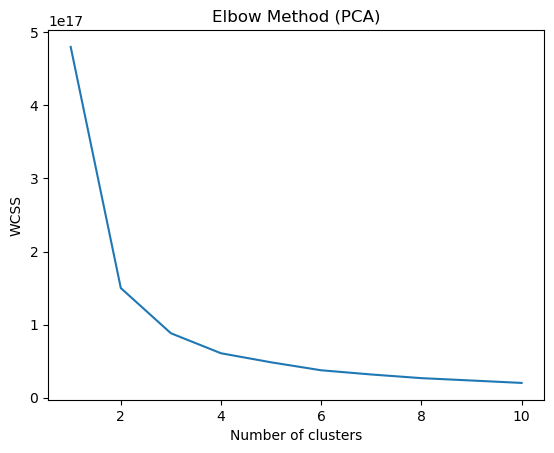

In [225]:
# finding the optimal number of cluster for the run with PCA

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method (PCA)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


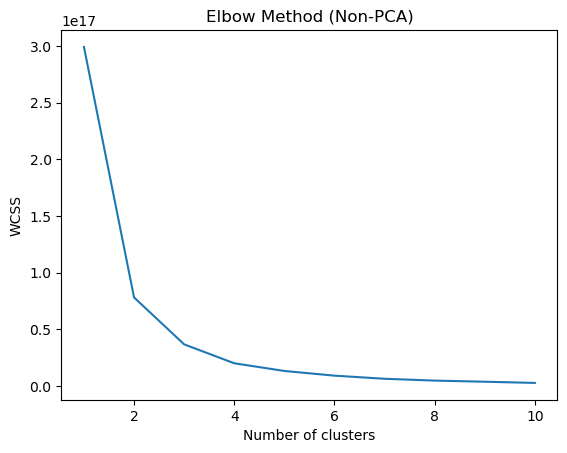

In [226]:
# finding the optimal number of cluster for the run without PCA

wcss2 = []
for i in range(1, 11):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans2.fit(df_no_pca)
    wcss2.append(kmeans2.inertia_)

plt.plot(range(1, 11), wcss2)
plt.title('Elbow Method (Non-PCA)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


> decided to go for 4 clusters for both models

> I have tested with 3, and while it wasnt bad, 4 had better seperation and centroids

## Buliding the Model

In [227]:
# Build the K-means model for PCA

kmeans_pca = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42)

In [228]:
# Build the K-means model for NO PCA set

kmeans_no_pca = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42)

## Train the Model

 ### K-Means


In [229]:
# Fit the PCA model
y_kmeans = kmeans_pca.fit_predict(df_pca)

In [230]:
# Fit the Non-PCA model
x_kmeans = kmeans_no_pca.fit_predict(df_no_pca)

## Evaluating the Model 

In [231]:
# creating a cluster column with the new clusters assignemnts
# for the PCA
df_pca['Cluster'] = y_kmeans


In [232]:
# creating a cluster column with the new clusters assignemnts
# for the NO PCA
df_no_pca['Cluster'] = x_kmeans


In [233]:
# PCA dataset
df_pca.head()

,PC1,PC2,PC3,Cluster
0,-2.623453e+06,-6.200566e+05,113.553748,0
1,2.537447e+07,-4.634557e+06,1623.898328,1
2,1.017634e+07,-1.026686e+06,-1171.528674,2
3,4.357312e+07,-7.243982e+06,-1795.757870,3
4,3.978006e+07,6.157984e+06,-1332.878517,3


In [234]:
# Non-PCA dataset
df_no_pca.head()

,appearance,minutes played,highest_value,Cluster
0,34.0,2758.0,2000000.0,1
1,89.0,7132.0,22000000.0,0
2,34.0,2686.0,12000000.0,0
3,72.0,5574.0,35000000.0,2
4,60.0,4783.0,40000000.0,2


In [235]:
# print inertia for for both models

inertia_pca = kmeans_pca.inertia_
inertia_no_pca = kmeans_no_pca.inertia_

print(f'PCA Model Inertia: {inertia_pca}')
print(f'Non-PCA Model Inertia: {inertia_pca}')


PCA Model Inertia: 6.08699550023837e+16
Non-PCA Model Inertia: 6.08699550023837e+16


In [236]:
# print silhouette_score for both models

silhouette_avg_pca = silhouette_score(df_pca, y_kmeans)
silhouette_avg_no_pca = silhouette_score(df_no_pca, x_kmeans)
print(f'Silhouette Score: {silhouette_avg_pca}')
print(f'Silhouette Score: {silhouette_avg_no_pca}')


Silhouette Score: 0.6724033563169277
Silhouette Score: 0.6931683383951731


In [237]:
# Number of points in each cluster for both models
unique, counts = np.unique(y_kmeans, return_counts=True)
unique2, counts2 = np.unique(x_kmeans, return_counts=True)

print(f'Cluster Sizes in PCA Model: {dict(zip(unique, counts))}')
print(f'Cluster Sizes in Non-PCA Model: {dict(zip(unique2, counts2))}')


Cluster Sizes in PCA Model: {0: 4846, 1: 370, 2: 1031, 3: 150}
Cluster Sizes in Non-PCA Model: {0: 459, 1: 4423, 2: 244, 3: 1271}


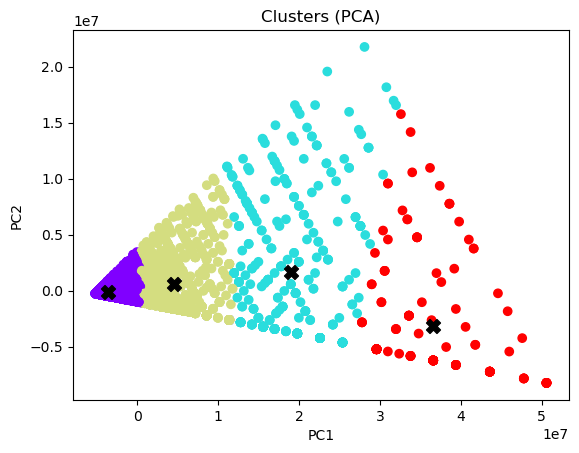

In [238]:
# plotting the clusters of the PCA Model
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=y_kmeans, cmap='rainbow')
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=100, c='black', marker='X')
plt.title('Clusters (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [239]:
df_no_pca

,appearance,minutes played,highest_value,Cluster
0,34.0,2758.0,2000000.0,1
1,89.0,7132.0,22000000.0,0
2,34.0,2686.0,12000000.0,0
3,72.0,5574.0,35000000.0,2
4,60.0,4783.0,40000000.0,2
...,...,...,...,...
6392,33.0,2375.0,750000.0,1
6393,12.0,813.0,1000000.0,1
6394,35.0,2160.0,3000000.0,1
6395,32.0,1588.0,200000.0,1


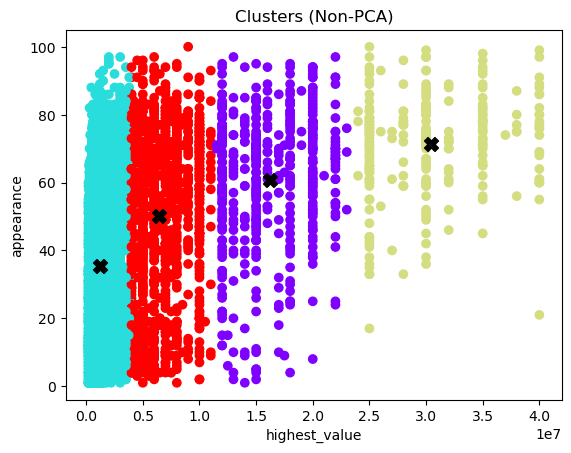

In [240]:
# plotting the clusters of the Non-PCA Model
plt.scatter(df_no_pca['highest_value'], df_no_pca['appearance'], c=x_kmeans, cmap='rainbow')
plt.scatter(kmeans_no_pca.cluster_centers_[:, 2], kmeans_no_pca.cluster_centers_[:, 0], s=100, c='black', marker='X')
plt.title('Clusters (Non-PCA)')
plt.xlabel('highest_value')
plt.ylabel('appearance')
plt.show()


In [241]:
from mpl_toolkits.mplot3d import Axes3D


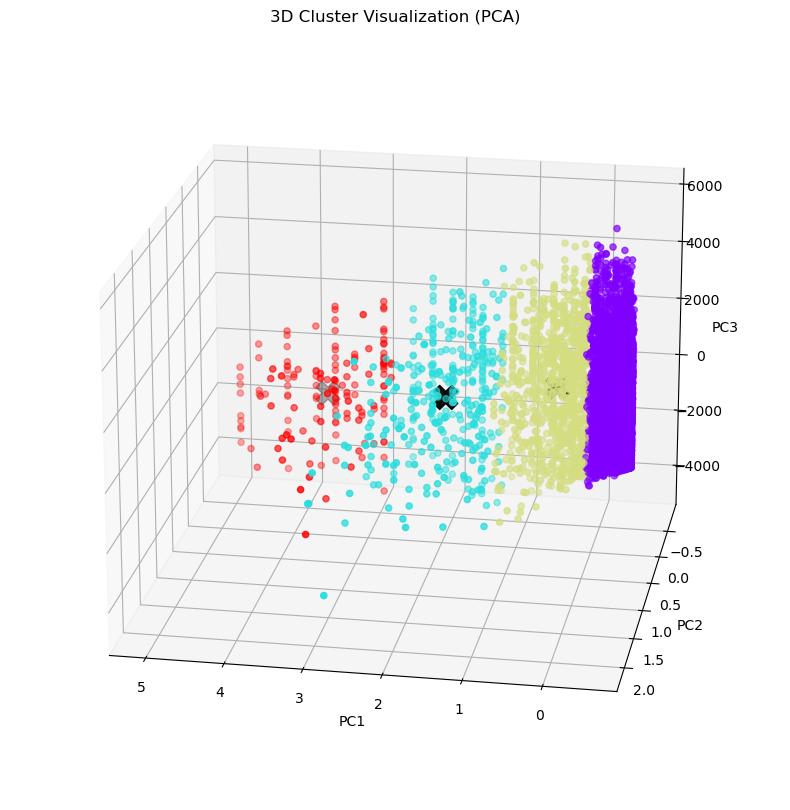

In [242]:
# Assuming 'X' has three features
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the three features and cluster assignments
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=y_kmeans, cmap='rainbow', marker='o')

# Plot the cluster centers
ax.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], kmeans_pca.cluster_centers_[:, 2], s=300, c='black', marker='X')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Cluster Visualization (PCA)')
ax.view_init(elev=20, azim=100)
plt.show()


In [243]:
df_no_pca

,appearance,minutes played,highest_value,Cluster
0,34.0,2758.0,2000000.0,1
1,89.0,7132.0,22000000.0,0
2,34.0,2686.0,12000000.0,0
3,72.0,5574.0,35000000.0,2
4,60.0,4783.0,40000000.0,2
...,...,...,...,...
6392,33.0,2375.0,750000.0,1
6393,12.0,813.0,1000000.0,1
6394,35.0,2160.0,3000000.0,1
6395,32.0,1588.0,200000.0,1


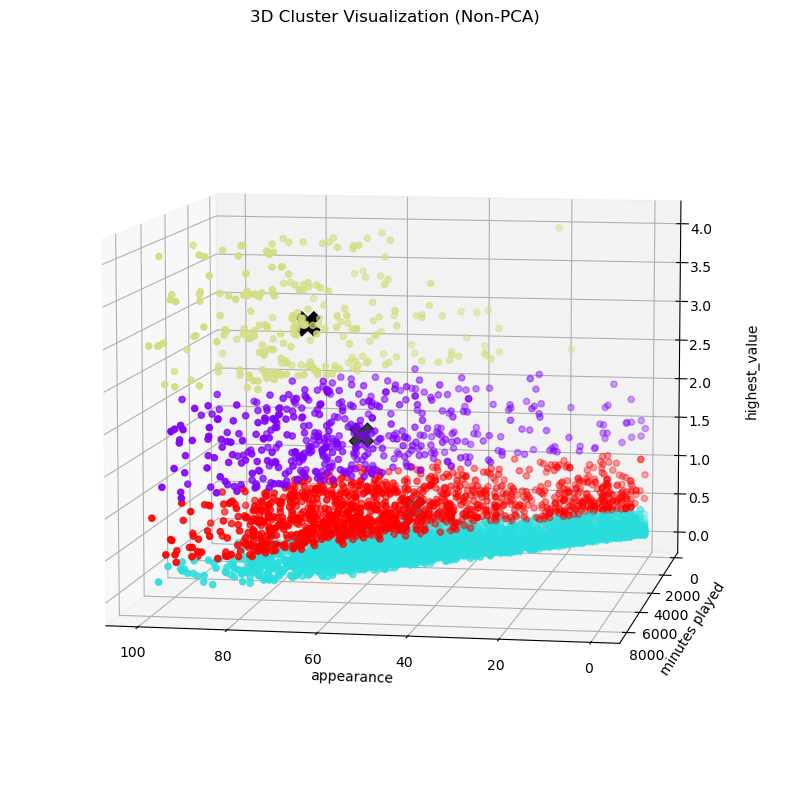

In [244]:
# Assuming 'X' has three features
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the three features and cluster assignments
ax.scatter(df_no_pca['appearance'], df_no_pca['minutes played'], df_no_pca['highest_value'], c=x_kmeans, cmap='rainbow', marker='o')

# Plot the cluster centers
ax.scatter(kmeans_no_pca.cluster_centers_[:, 0], kmeans_no_pca.cluster_centers_[:, 1], kmeans_no_pca.cluster_centers_[:, 2], s=300, c='black', marker='X')

# Labels and title
ax.view_init(elev=8, azim=100)
ax.set_xlabel('appearance')
ax.set_ylabel('minutes played')
ax.set_zlabel('highest_value', labelpad=20)
ax.set_title('3D Cluster Visualization (Non-PCA)')
plt.show()
